In [1]:
# !gsutil cp -r gs://volume_ai_1yr_daily_data/* /home/jupyter/lstm/

In [ ]:
# !pip install captum

## Install Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from plotnine import *
from plotnine.data import *
import random
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from captum.attr import IntegratedGradients
from plotnine.data import *
import seaborn as sns
import gc

## Import Training Data

In [5]:
X_30d_minmaxscaler = np.load('/home/jupyter/lstm/training_array/X_30d_minmaxscaler_feaonly_first4mon_202401_03.npy')
y_30d_minmaxscaler = np.load('/home/jupyter/lstm/training_array/y_30d_minmaxscaler_feaonly_first4mon_202401_03.npy')

In [28]:
user_df_minmaxscaler = np.load('/home/jupyter/lstm/training_array/static_array_first4mon_202401_03.npy')

### Split Train-Test data

In [6]:
X_train_all, X_test, y_train_all, y_test, fea_train_all, fea_test = train_test_split(X_30d_minmaxscaler, y_30d_minmaxscaler, user_array, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, fea_train, fea_val = train_test_split(X_train_all, y_train_all, fea_train_all, test_size=0.1, random_state=42)

In [7]:
y_train.sum()/len(y_train)

0.8392102252946735

In [8]:
y_test.sum()/len(y_test)

0.8376152537821144

In [9]:
y_val.sum()/len(y_val)

0.8379950771984784

In [10]:
X_train.shape

(40214, 4, 69)

In [11]:
fea_train.shape

(40214, 29)

In [12]:
y_train.shape

(40214,)

In [13]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
fea_train = torch.from_numpy(fea_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
fea_test = torch.from_numpy(fea_test).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().unsqueeze(-1)
fea_val = torch.from_numpy(fea_val).float()

## Performance Evaluation Function

In [15]:
def evaluate_model(model, X_test, y_test, fea_test):
    model.eval()
    with torch.no_grad():
        y_test_list = []
        y_pred_list = [] 
        for seq, labels, feature in zip(X_test, y_test, fea_test):
            seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
            y_pred = model(seq.unsqueeze(0), feature.unsqueeze(0))
            y_pred = (y_pred > 0.5).float()
            
            y_test_list.append(labels.squeeze().tolist())
            y_pred_list.append(y_pred.squeeze().tolist())
    
    
    target_names = ['Non-Active', 'Active']
    print(classification_report(y_test_list, y_pred_list, target_names=target_names))

## GRU Model, Add Static feature layer

### Static Data Concat

#### Final Model

 10%|█         | 10/100 [00:38<05:47,  3.86s/it]

Epoch  10, Train Loss: 0.17129144, Val Loss: 0.33350199
Epoch  10, Loss: 0.17129144072532654, Learning Rate: 2.800115440700391e-05


 20%|██        | 20/100 [01:17<05:07,  3.85s/it]

Epoch  20, Train Loss: 0.29069829, Val Loss: 0.29834172
Epoch  20, Loss: 0.2906982898712158, Learning Rate: 7.60023087584805e-05


 30%|███       | 30/100 [01:55<04:28,  3.83s/it]

Epoch  30, Train Loss: 0.29749402, Val Loss: 0.12137920
Epoch  30, Loss: 0.2974940240383148, Learning Rate: 9.999999996813078e-05


 40%|████      | 40/100 [02:34<03:49,  3.82s/it]

Epoch  40, Train Loss: 0.25750342, Val Loss: 0.27815869
Epoch  40, Loss: 0.2575034201145172, Learning Rate: 9.504768860705023e-05


 50%|█████     | 50/100 [03:12<03:11,  3.83s/it]

Epoch  50, Train Loss: 0.21424437, Val Loss: 0.24807462
Epoch  50, Loss: 0.21424436569213867, Learning Rate: 8.117316965615154e-05


 60%|██████    | 60/100 [03:50<02:32,  3.82s/it]

Epoch  60, Train Loss: 0.17890437, Val Loss: 0.18598947
Epoch  60, Loss: 0.17890436947345734, Learning Rate: 6.112446175346842e-05


 70%|███████   | 70/100 [04:28<01:54,  3.80s/it]

Epoch  70, Train Loss: 0.27366138, Val Loss: 0.27417797
Epoch  70, Loss: 0.27366137504577637, Learning Rate: 3.88724573803937e-05


 80%|████████  | 80/100 [05:07<01:17,  3.87s/it]

Epoch  80, Train Loss: 0.32966918, Val Loss: 0.26438719
Epoch  80, Loss: 0.32966917753219604, Learning Rate: 1.8824438905939206e-05


 90%|█████████ | 90/100 [05:45<00:38,  3.83s/it]

Epoch  90, Train Loss: 0.35073099, Val Loss: 0.10550983
Epoch  90, Loss: 0.3507309854030609, Learning Rate: 4.951162261781821e-06


100%|██████████| 100/100 [06:24<00:00,  3.84s/it]

Epoch 100, Train Loss: 0.19502337, Val Loss: 0.14021774
Epoch 100, Loss: 0.19502337276935577, Learning Rate: 4.000318692185736e-10


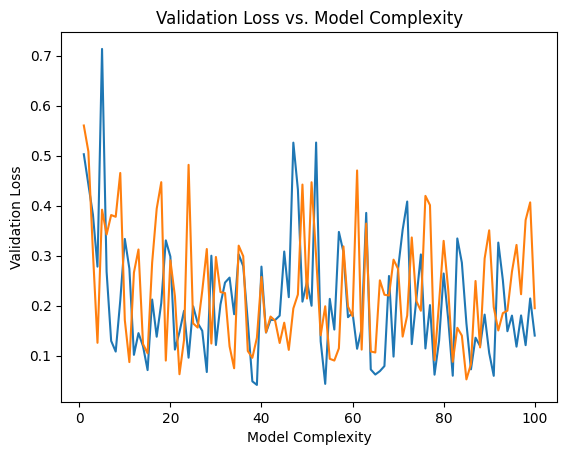

In [ ]:
# Min-max Scaler (Final Version)
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

In [ ]:
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea3.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
evaluate_model(model, X_test, y_test, fea_test)

              precision    recall  f1-score   support

  Non-Active       0.77      0.72      0.74      2080
      Active       0.94      0.95      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.85      0.84      0.84     11171
weighted avg       0.91      0.91      0.91     11171



In [ ]:
evaluate_model(best_model, X_train, y_train, fea_train)

              precision    recall  f1-score   support

  Non-Active       0.79      0.73      0.76      7503
      Active       0.94      0.96      0.95     32711

    accuracy                           0.91     40214
   macro avg       0.87      0.84      0.85     40214
weighted avg       0.91      0.91      0.91     40214



In [ ]:
evaluate_model(best_model, X_val, y_val, fea_val)

              precision    recall  f1-score   support

  Non-Active       0.79      0.71      0.75       842
      Active       0.93      0.96      0.94      3627

    accuracy                           0.91      4469
   macro avg       0.86      0.83      0.85      4469
weighted avg       0.91      0.91      0.91      4469



In [ ]:
## Final Model
# Min-max Scaler
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels, feature in zip(X_test, y_test, fea_test):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        y_pred = (y_pred > 0.45).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.80      0.68      0.73      2080
      Active       0.93      0.96      0.94      9091

    accuracy                           0.91     11171
   macro avg       0.86      0.82      0.84     11171
weighted avg       0.90      0.91      0.90     11171



#### Final Model (First 4 months)

 10%|█         | 10/100 [00:40<05:57,  3.97s/it]

Epoch  10, Train Loss: 0.01896450, Val Loss: 0.23765855
Epoch  10, Loss: 0.0189644955098629, Learning Rate: 2.800115440700391e-05


 20%|██        | 20/100 [01:20<05:16,  3.96s/it]

Epoch  20, Train Loss: 0.08691701, Val Loss: 0.25352159
Epoch  20, Loss: 0.08691700547933578, Learning Rate: 7.60023087584805e-05


 30%|███       | 30/100 [01:59<04:36,  3.95s/it]

Epoch  30, Train Loss: 0.25479150, Val Loss: 0.25915962
Epoch  30, Loss: 0.2547914981842041, Learning Rate: 9.999999996813078e-05


 40%|████      | 40/100 [02:39<03:58,  3.97s/it]

Epoch  40, Train Loss: 0.09713611, Val Loss: 0.21498762
Epoch  40, Loss: 0.09713611006736755, Learning Rate: 9.504768860705023e-05


 50%|█████     | 50/100 [03:19<03:21,  4.02s/it]

Epoch  50, Train Loss: 0.17224026, Val Loss: 0.27854174
Epoch  50, Loss: 0.1722402572631836, Learning Rate: 8.117316965615154e-05


 60%|██████    | 60/100 [03:58<02:39,  3.99s/it]

Epoch  60, Train Loss: 0.04777525, Val Loss: 0.12076438
Epoch  60, Loss: 0.047775253653526306, Learning Rate: 6.112446175346842e-05


 70%|███████   | 70/100 [04:38<01:58,  3.94s/it]

Epoch  70, Train Loss: 0.36638513, Val Loss: 0.15875633
Epoch  70, Loss: 0.3663851320743561, Learning Rate: 3.88724573803937e-05


 80%|████████  | 80/100 [05:18<01:19,  3.95s/it]

Epoch  80, Train Loss: 0.22276375, Val Loss: 0.21102445
Epoch  80, Loss: 0.22276374697685242, Learning Rate: 1.8824438905939206e-05


 90%|█████████ | 90/100 [05:57<00:39,  3.95s/it]

Epoch  90, Train Loss: 0.20613344, Val Loss: 0.20541671
Epoch  90, Loss: 0.20613344013690948, Learning Rate: 4.951162261781821e-06


100%|██████████| 100/100 [06:37<00:00,  3.97s/it]

Epoch 100, Train Loss: 0.09394846, Val Loss: 0.07094622
Epoch 100, Loss: 0.09394846111536026, Learning Rate: 4.000318692185736e-10


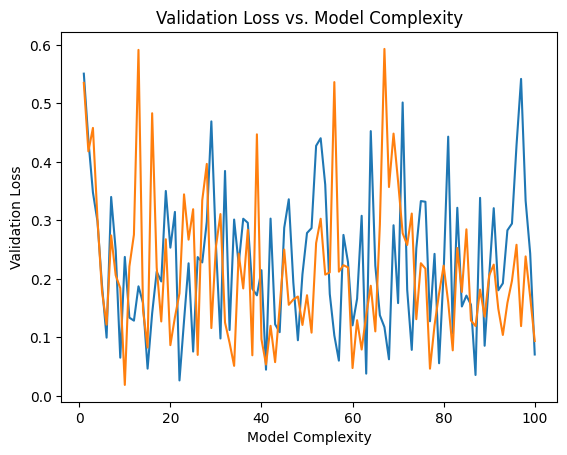

In [ ]:
# Min-max Scaler (Final Version, first 4 months)
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

In [ ]:
# Min-Max Scaler
evaluate_model(model, X_test, y_test, fea_test)

              precision    recall  f1-score   support

  Non-Active       0.78      0.70      0.74      1814
      Active       0.94      0.96      0.95      9357

    accuracy                           0.92     11171
   macro avg       0.86      0.83      0.85     11171
weighted avg       0.92      0.92      0.92     11171



In [ ]:
evaluate_model(model, X_train, y_train, fea_train)

              precision    recall  f1-score   support

  Non-Active       0.78      0.71      0.74      6466
      Active       0.94      0.96      0.95     33748

    accuracy                           0.92     40214
   macro avg       0.86      0.83      0.85     40214
weighted avg       0.92      0.92      0.92     40214



In [ ]:
evaluate_model(model, X_val, y_val, fea_val)

              precision    recall  f1-score   support

  Non-Active       0.77      0.69      0.73       724
      Active       0.94      0.96      0.95      3745

    accuracy                           0.92      4469
   macro avg       0.86      0.82      0.84      4469
weighted avg       0.91      0.92      0.91      4469



In [ ]:
# first 4 months
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea_first4mon.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
# Min-max Scaler
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels, feature in zip(X_test, y_test, fea_test):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        y_pred = (y_pred > 0.40).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.80      0.66      0.72      1814
      Active       0.94      0.97      0.95      9357

    accuracy                           0.92     11171
   macro avg       0.87      0.82      0.84     11171
weighted avg       0.91      0.92      0.92     11171



#### Final Model (First 4 months, label the 7th month)

In [ ]:
# Min-max Scaler (Final Version, first 4 months, label the 7th month)
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

 10%|█         | 10/100 [00:42<06:23,  4.26s/it]

Epoch  10, Train Loss: 0.09574632, Val Loss: 0.11521777
Epoch  10, Loss: 0.09574631601572037, Learning Rate: 7.916752982251494e-05


 20%|██        | 20/100 [01:24<05:37,  4.22s/it]

Epoch  20, Train Loss: 0.28762770, Val Loss: 0.14442474
Epoch  20, Loss: 0.2876276969909668, Learning Rate: 9.997202242573345e-05


 30%|███       | 30/100 [02:06<04:55,  4.22s/it]

Epoch  30, Train Loss: 0.31113672, Val Loss: 0.28170452
Epoch  30, Loss: 0.31113672256469727, Learning Rate: 9.429762369935957e-05


 40%|████      | 40/100 [02:48<04:14,  4.24s/it]

Epoch  40, Train Loss: 0.31007352, Val Loss: 0.40499324
Epoch  40, Loss: 0.31007352471351624, Learning Rate: 7.984957693707811e-05


 50%|█████     | 50/100 [03:31<03:32,  4.25s/it]

Epoch  50, Train Loss: 0.18700007, Val Loss: 0.62714452
Epoch  50, Loss: 0.1870000660419464, Learning Rate: 5.948949499382411e-05


 60%|██████    | 60/100 [04:13<02:48,  4.21s/it]

Epoch  60, Train Loss: 0.17150992, Val Loss: 0.27242869
Epoch  60, Loss: 0.17150992155075073, Learning Rate: 3.7249941798477505e-05


 70%|███████   | 70/100 [04:56<02:07,  4.25s/it]

Epoch  70, Train Loss: 0.36446720, Val Loss: 0.23309387
Epoch  70, Loss: 0.36446720361709595, Learning Rate: 1.7535733611597364e-05


 80%|████████  | 80/100 [05:38<01:24,  4.20s/it]

Epoch  80, Train Loss: 0.29528961, Val Loss: 0.49707547
Epoch  80, Loss: 0.2952896058559418, Learning Rate: 4.251511143491993e-06


 89%|████████▉ | 89/100 [06:17<00:46,  4.24s/it]


ValueError: Tried to step 125701 times. The specified number of total steps is 125700

In [ ]:
evaluate_model(model, X_test, y_test, fea_test)

              precision    recall  f1-score   support

  Non-Active       0.74      0.64      0.69      2080
      Active       0.92      0.95      0.93      9091

    accuracy                           0.89     11171
   macro avg       0.83      0.80      0.81     11171
weighted avg       0.89      0.89      0.89     11171



In [ ]:
evaluate_model(model, X_train, y_train, fea_train)

              precision    recall  f1-score   support

  Non-Active       0.76      0.65      0.70      7503
      Active       0.92      0.95      0.94     32711

    accuracy                           0.90     40214
   macro avg       0.84      0.80      0.82     40214
weighted avg       0.89      0.90      0.89     40214



In [ ]:
evaluate_model(model, X_val, y_val, fea_val)

              precision    recall  f1-score   support

  Non-Active       0.74      0.61      0.67       842
      Active       0.91      0.95      0.93      3627

    accuracy                           0.89      4469
   macro avg       0.83      0.78      0.80      4469
weighted avg       0.88      0.89      0.88      4469



In [ ]:
# first 4 months
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea_first4mon_label7mon.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
# Min-max Scaler
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels, feature in zip(X_test, y_test, fea_test):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        y_pred = (y_pred > 0.43).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.76      0.60      0.67      2080
      Active       0.91      0.96      0.93      9091

    accuracy                           0.89     11171
   macro avg       0.84      0.78      0.80     11171
weighted avg       0.88      0.89      0.89     11171



#### Final Model (First 5 months, label the 7th month)

 10%|█         | 10/100 [00:43<06:28,  4.31s/it]

Epoch  10, Train Loss: 0.20637758, Val Loss: 0.27049682
Epoch  10, Loss: 0.20637758076190948, Learning Rate: 2.800115440700391e-05


 20%|██        | 20/100 [01:25<05:42,  4.28s/it]

Epoch  20, Train Loss: 0.19340301, Val Loss: 0.13026212
Epoch  20, Loss: 0.19340300559997559, Learning Rate: 7.60023087584805e-05


 30%|███       | 30/100 [02:09<05:00,  4.29s/it]

Epoch  30, Train Loss: 0.24598572, Val Loss: 0.21194340
Epoch  30, Loss: 0.2459857165813446, Learning Rate: 9.999999996813078e-05


 40%|████      | 40/100 [02:51<04:16,  4.27s/it]

Epoch  40, Train Loss: 0.25652838, Val Loss: 0.53085721
Epoch  40, Loss: 0.256528377532959, Learning Rate: 9.504768860705023e-05


 50%|█████     | 50/100 [03:34<03:31,  4.24s/it]

Epoch  50, Train Loss: 0.21689385, Val Loss: 0.18461998
Epoch  50, Loss: 0.21689385175704956, Learning Rate: 8.117316965615154e-05


 60%|██████    | 60/100 [04:17<02:52,  4.31s/it]

Epoch  60, Train Loss: 0.10566480, Val Loss: 0.60278016
Epoch  60, Loss: 0.10566479712724686, Learning Rate: 6.112446175346842e-05


 70%|███████   | 70/100 [05:00<02:08,  4.29s/it]

Epoch  70, Train Loss: 0.04083158, Val Loss: 0.18945965
Epoch  70, Loss: 0.04083157703280449, Learning Rate: 3.88724573803937e-05


 80%|████████  | 80/100 [05:42<01:25,  4.28s/it]

Epoch  80, Train Loss: 0.35068807, Val Loss: 0.30175719
Epoch  80, Loss: 0.35068807005882263, Learning Rate: 1.8824438905939206e-05


 90%|█████████ | 90/100 [06:26<00:43,  4.31s/it]

Epoch  90, Train Loss: 0.14840248, Val Loss: 0.15527181
Epoch  90, Loss: 0.14840248227119446, Learning Rate: 4.951162261781821e-06


100%|██████████| 100/100 [07:09<00:00,  4.29s/it]

Epoch 100, Train Loss: 0.25568834, Val Loss: 0.34331071
Epoch 100, Loss: 0.255688339471817, Learning Rate: 4.000318692185736e-10


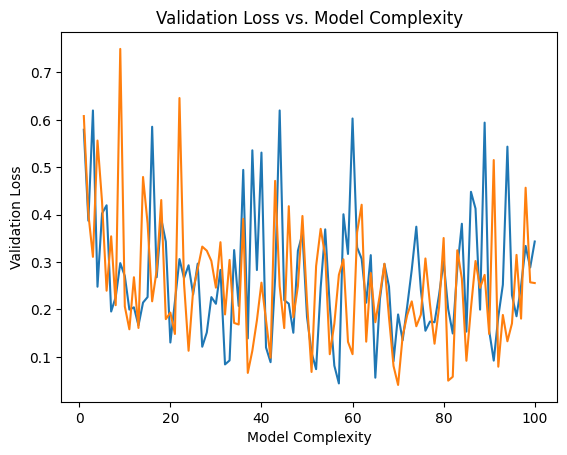

In [ ]:
# Min-max Scaler (Final Version, first 5 months, label the 7th month)
train_model(model, optimizer, dataloader_train, dataloader_val, scheduler, epochs)

In [ ]:
evaluate_model(model, X_test, y_test, fea_test)

              precision    recall  f1-score   support

  Non-Active       0.76      0.68      0.72      2080
      Active       0.93      0.95      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.84      0.81      0.83     11171
weighted avg       0.90      0.90      0.90     11171



In [ ]:
evaluate_model(model, X_train, y_train, fea_train)

              precision    recall  f1-score   support

  Non-Active       0.78      0.68      0.73      7503
      Active       0.93      0.96      0.94     32711

    accuracy                           0.91     40214
   macro avg       0.86      0.82      0.84     40214
weighted avg       0.90      0.91      0.90     40214



In [ ]:
evaluate_model(model, X_val, y_val, fea_val)

              precision    recall  f1-score   support

  Non-Active       0.76      0.65      0.70       842
      Active       0.92      0.95      0.94      3627

    accuracy                           0.90      4469
   macro avg       0.84      0.80      0.82      4469
weighted avg       0.89      0.90      0.89      4469



In [ ]:
# first 5 months
best_model_path = '/home/jupyter/lstm/model/gru_best_model_weightdecay001_staticfea_first5mon_label7mon.pt'
best_model = GRUModel(input_dim=X_train.shape[2], hidden_dim=128, output_dim=y_train.shape[1], feature_dim=fea_train.shape[1]).to(device)
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
# Min-max Scaler
best_model.eval()
with torch.no_grad():
    y_test_list = []
    y_pred_list = [] 
    for seq, labels, feature in zip(X_test, y_test, fea_test):
        seq, labels, feature = seq.to(device).float(), labels.to(device).float(), feature.to(device).float()
        y_pred = best_model(seq.unsqueeze(0), feature.unsqueeze(0))
        y_pred = (y_pred > 0.41).float()

        y_test_list.append(labels.squeeze().tolist())
        y_pred_list.append(y_pred.squeeze().tolist())


target_names = ['Non-Active', 'Active']
print(classification_report(y_test_list, y_pred_list, target_names=target_names))

              precision    recall  f1-score   support

  Non-Active       0.80      0.63      0.70      2080
      Active       0.92      0.96      0.94      9091

    accuracy                           0.90     11171
   macro avg       0.86      0.80      0.82     11171
weighted avg       0.90      0.90      0.90     11171

